In [ ]:
# !pip install gym==0.26.2

In [2]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# !pip uninstall numpy
# !pip install numpy==1.23.5

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Experiment 1 - 8 hidden neurons

In [ ]:
# Dueling DQN network
class DuelingDQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DuelingDQN, self).__init__()
        self.feature = nn.Sequential(
            nn.Linear(state_dim, 16),
            nn.ReLU()
        )
        self.value_stream = nn.Sequential(
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )
        self.advantage_stream = nn.Sequential(
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, action_dim)
        )

    def forward(self, x):
        features = self.feature(x)
        values = self.value_stream(features)
        advantages = self.advantage_stream(features)
        return values + (advantages - advantages.mean(dim=1, keepdim=True))

In [ ]:
# Setup
env = gym.make("MountainCar-v0")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

q_net = DuelingDQN(state_dim, action_dim)
target_q_net = DuelingDQN(state_dim, action_dim)
target_q_net.load_state_dict(q_net.state_dict())
optimizer = optim.Adam(q_net.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

replay_buffer = deque(maxlen=100000)

In [ ]:
# Training function
def train():
    if len(replay_buffer) < batch_size:
        return
    # Sample training batch from replay buffer
    batch = random.sample(replay_buffer, batch_size)
    # Unpacking batch
    states, actions, rewards, next_states, dones = zip(*batch)
    # Convert states, actions, rewards, next_states, dones into torch tensor type
    states = torch.tensor([np.array(s, dtype=np.float32) for s in states], dtype=torch.float32)
    actions = torch.tensor(actions).unsqueeze(1)
    rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
    next_states = torch.tensor([np.array(s, dtype=np.float32) for s in next_states], dtype=torch.float32)
    dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

    q_values = q_net(states).gather(1, actions)
    with torch.no_grad():
        max_next_q = target_q_net(next_states).max(1, keepdim=True)[0]
        q_targets = rewards + (1 - dones) * gamma * max_next_q

    loss = nn.MSELoss()(q_values, q_targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
# Hyperparameters
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.1
batch_size = 32
target_update_freq = 100

In [ ]:
# Main training loop
# Create a df to store episode and number of steps
df_epsisode = pd.DataFrame(columns=['Episode','Num_steps', 'Reward'])

for episode in range(10000):
    state, _ = env.reset()
    done = False
    total_reward = 0
    num_step = 0
    reward_per_episode = 0
    while not done:
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                action = q_net(torch.tensor([state], dtype=torch.float32)).argmax().item()

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Store to replay buffer
        replay_buffer.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward
        # Track number of steps
        num_step = num_step+1
        # Track reward per episode
        reward_per_episode += reward

        train()

    new_track = {'Episode':episode, 'Num_steps':num_step, 'Reward':reward_per_episode}
    df_epsisode.loc[len(df_epsisode)] = new_track

    max_buffer_size = 10000
    if len(replay_buffer) > max_buffer_size:
        replay_buffer.popleft()  # Remove oldest experience

    if epsilon > epsilon_min:
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

    if episode % target_update_freq == 0:
        target_q_net.load_state_dict(q_net.state_dict())

    if episode % 100 == 0:
      print(f"Episode {episode}, Reward: {total_reward:.1f}, Epsilon: {epsilon:.3f}")

env.close()

Episode 0, Reward: -200.0, Epsilon: 0.100
Episode 100, Reward: -200.0, Epsilon: 0.100
Episode 200, Reward: -200.0, Epsilon: 0.100
Episode 300, Reward: -200.0, Epsilon: 0.100
Episode 400, Reward: -200.0, Epsilon: 0.100
Episode 500, Reward: -200.0, Epsilon: 0.100
Episode 600, Reward: -200.0, Epsilon: 0.100
Episode 700, Reward: -200.0, Epsilon: 0.100
Episode 800, Reward: -200.0, Epsilon: 0.100
Episode 900, Reward: -200.0, Epsilon: 0.100
Episode 1000, Reward: -163.0, Epsilon: 0.100
Episode 1100, Reward: -177.0, Epsilon: 0.100
Episode 1200, Reward: -167.0, Epsilon: 0.100
Episode 1300, Reward: -146.0, Epsilon: 0.100
Episode 1400, Reward: -200.0, Epsilon: 0.100
Episode 1500, Reward: -158.0, Epsilon: 0.100
Episode 1600, Reward: -154.0, Epsilon: 0.100
Episode 1700, Reward: -152.0, Epsilon: 0.100
Episode 1800, Reward: -105.0, Epsilon: 0.100
Episode 1900, Reward: -160.0, Epsilon: 0.100
Episode 2000, Reward: -167.0, Epsilon: 0.100
Episode 2100, Reward: -164.0, Epsilon: 0.100
Episode 2200, Reward: 

In [ ]:
df_epsisode.to_csv("experiment2.csv")

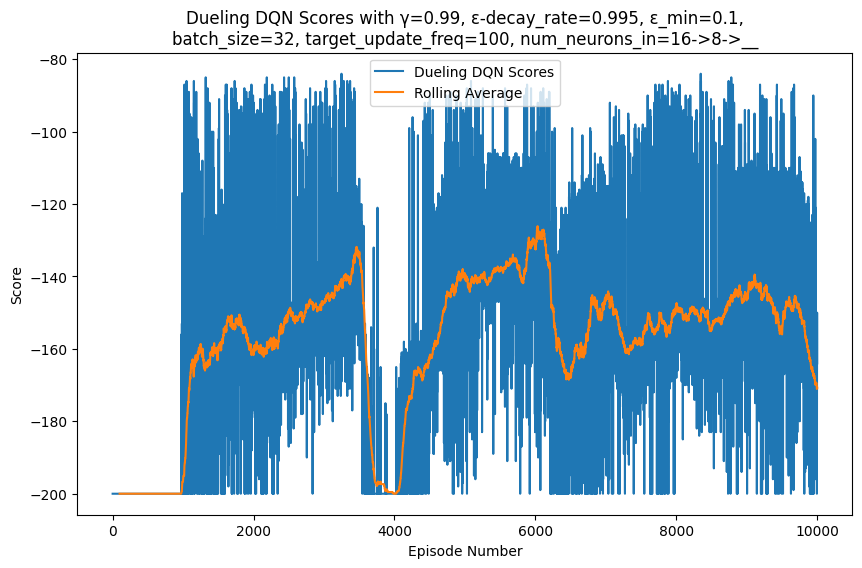

In [ ]:
df_epsisode2 = pd.read_csv("/content/drive/MyDrive/DRL/experiment2.csv")
double_dqn_scores_series = pd.Series(df_epsisode2['Reward'], name="scores")

fig, axes = plt.subplots(1, 1, figsize=(10, 6), sharex=True, sharey=True)
_ = double_dqn_scores_series.plot(ax=axes, label="Dueling DQN Scores")
_ = (double_dqn_scores_series.rolling(window=100)
                      .mean()
                      .rename("Rolling Average")
                      .plot(ax=axes))
_ = axes.legend()
_ = axes.set_ylabel("Score")
_ = axes.set_xlabel("Episode Number")
_ = axes.set_title("Dueling DQN Scores with γ=0.99, ε-decay_rate=0.995, ε_min=0.1,\n"
                  "batch_size=32, target_update_freq=100, num_neurons_in=16->8->__")

In [16]:
# Count number of successful runs
num_successful_runs = df_epsisode2[df_epsisode2['Reward'] > -200].shape[0]
print(f"Number of successful runs: {num_successful_runs}")

Number of successful runs: 8245


In [19]:
max_reward = df_epsisode2['Reward'].max()
df_epsisode2[df_epsisode2['Reward'] == max_reward]

,Unnamed: 0,Episode,Num_steps,Reward
3248,3248,3248,84,-84.0
8346,8346,8346,84,-84.0


In [21]:
# Calculate the last rolling average
rolling_average = df_epsisode2['Reward'].tail(100).mean()
print(f"Last 100 episode rolling average: {rolling_average}")

Last 100 episode rolling average: -170.84


## Experiment 2

In [ ]:
# Dueling DQN network
class DuelingDQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DuelingDQN, self).__init__()
        self.feature = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU()
        )
        self.value_stream = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        self.advantage_stream = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, action_dim)
        )

    def forward(self, x):
        features = self.feature(x)
        values = self.value_stream(features)
        advantages = self.advantage_stream(features)
        return values + (advantages - advantages.mean(dim=1, keepdim=True))

In [ ]:
# Hyperparameters
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.01
batch_size = 32
target_update_freq = 100

In [ ]:
# Main training loop
# Create a df to store episode and number of steps
df_epsisode = pd.DataFrame(columns=['Episode','Num_steps', 'Reward'])

for episode in range(10000):
    state, _ = env.reset()
    done = False
    total_reward = 0
    num_step = 0
    reward_per_episode = 0
    while not done:
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                action = q_net(torch.tensor([state], dtype=torch.float32)).argmax().item()

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Store to replay buffer
        replay_buffer.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward
        # Track number of steps
        num_step = num_step+1
        # Track reward per episode
        reward_per_episode += reward

        train()

    new_track = {'Episode':episode, 'Num_steps':num_step, 'Reward':reward_per_episode}
    df_epsisode.loc[len(df_epsisode)] = new_track

    max_buffer_size = 10000
    if len(replay_buffer) > max_buffer_size:
        replay_buffer.popleft()  # Remove oldest experience

    if epsilon > epsilon_min:
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

    if episode % target_update_freq == 0:
        target_q_net.load_state_dict(q_net.state_dict())

    if episode % 100 == 0:
      print(f"Episode {episode}, Reward: {total_reward:.1f}, Epsilon: {epsilon:.3f}")

env.close()

Episode 0, Reward: -200.0, Epsilon: 0.995
Episode 100, Reward: -200.0, Epsilon: 0.603
Episode 200, Reward: -200.0, Epsilon: 0.365
Episode 300, Reward: -200.0, Epsilon: 0.221
Episode 400, Reward: -200.0, Epsilon: 0.134
Episode 500, Reward: -200.0, Epsilon: 0.081
Episode 600, Reward: -200.0, Epsilon: 0.049
Episode 700, Reward: -200.0, Epsilon: 0.030
Episode 800, Reward: -200.0, Epsilon: 0.018
Episode 900, Reward: -200.0, Epsilon: 0.011
Episode 1000, Reward: -200.0, Epsilon: 0.010
Episode 1100, Reward: -200.0, Epsilon: 0.010
Episode 1200, Reward: -200.0, Epsilon: 0.010
Episode 1300, Reward: -200.0, Epsilon: 0.010
Episode 1400, Reward: -200.0, Epsilon: 0.010
Episode 1500, Reward: -200.0, Epsilon: 0.010
Episode 1600, Reward: -200.0, Epsilon: 0.010
Episode 1700, Reward: -200.0, Epsilon: 0.010
Episode 1800, Reward: -200.0, Epsilon: 0.010
Episode 1900, Reward: -200.0, Epsilon: 0.010
Episode 2000, Reward: -200.0, Epsilon: 0.010
Episode 2100, Reward: -200.0, Epsilon: 0.010
Episode 2200, Reward: 

In [ ]:
#df_epsisode.to_csv("/content/drive/MyDrive/DRL/experiement3.csv")

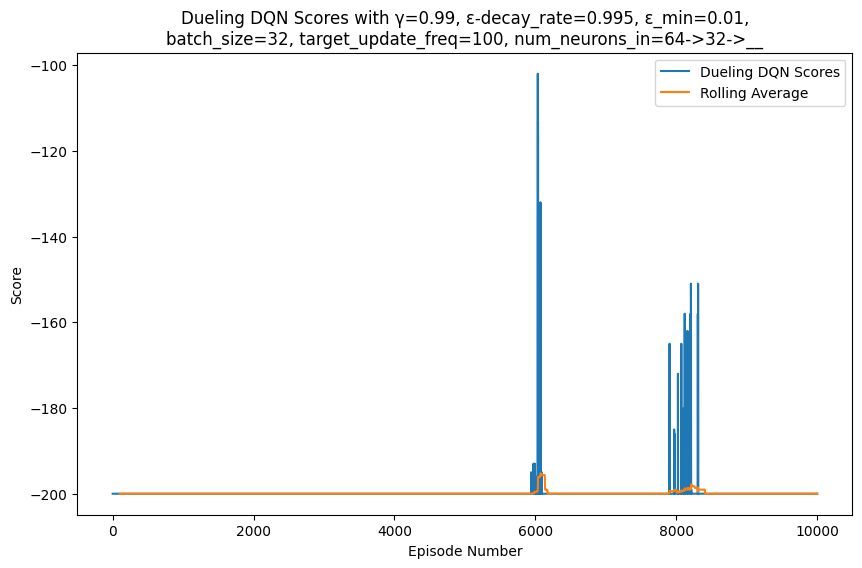

In [6]:
df_epsisode3 = pd.read_csv("/content/drive/MyDrive/DRL/experiement3.csv")
double_dqn_scores_series = pd.Series(df_epsisode3['Reward'], name="scores")

fig, axes = plt.subplots(1, 1, figsize=(10, 6), sharex=True, sharey=True)
_ = double_dqn_scores_series.plot(ax=axes, label="Dueling DQN Scores")
_ = (double_dqn_scores_series.rolling(window=100)
                      .mean()
                      .rename("Rolling Average")
                      .plot(ax=axes))
_ = axes.legend()
_ = axes.set_ylabel("Score")
_ = axes.set_xlabel("Episode Number")
_ = axes.set_title("Dueling DQN Scores with γ=0.99, ε-decay_rate=0.995, ε_min=0.01,\n"
                   "batch_size=32, target_update_freq=100, num_neurons_in=64->32->__")

In [ ]:
df_epsisode3

,Unnamed: 0,Episode,Num_steps,Reward
0,0,0,200,-200.0
1,1,1,200,-200.0
2,2,2,200,-200.0
3,3,3,200,-200.0
4,4,4,200,-200.0
...,...,...,...,...
9995,9995,9995,200,-200.0
9996,9996,9996,200,-200.0
9997,9997,9997,200,-200.0
9998,9998,9998,200,-200.0


In [7]:
# Count number of successful runs
num_successful_runs3 = df_epsisode3[df_epsisode3['Reward'] > -200].shape[0]
print(f"Number of successful runs: {num_successful_runs3}")

Number of successful runs: 40


In [17]:
max_reward = df_epsisode3['Reward'].max()
df_epsisode3[df_epsisode3['Reward'] == max_reward]

,Unnamed: 0,Episode,Num_steps,Reward
6034,6034,6034,102,-102.0
